In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset_path = os.path.join('../input/anndlhw2/Training.csv')

In [4]:
X = np.genfromtxt('../input/anndlhw2/Training.csv',delimiter=',',skip_header=True)

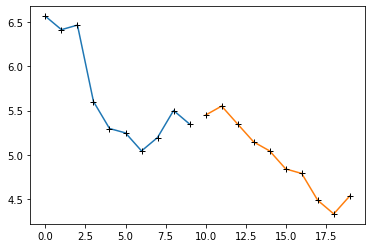

In [5]:
# Defining split sizes 

test_size = 1152
train_size = len(X) - test_size

train_raw = X[:train_size]
test_raw = X[train_size:]

train_raw.shape, test_raw.shape

plt.plot(figsize=(20,5))
plt.plot(range(10),train_raw[-10:,0])
plt.plot(range(10,20),test_raw[:10,0])
plt.plot(range(0,20),X[train_size-10:train_size+10,0],'+k')

In [6]:
# Pre-processing

train_max = train_raw.max(axis=0)
train_min = train_raw.min(axis=0)

X_mean = train_raw.mean(axis=0)
X_std = train_raw.std(axis=0)

train_scaled = (train_raw-train_min)/(train_max-train_min)
test_scaled = (test_raw-train_min)/(train_max-train_min)

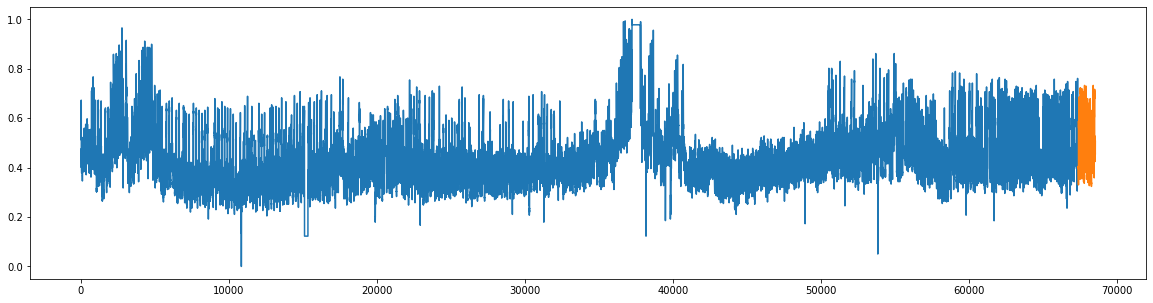

In [7]:
i=0
plt.figure(figsize=(20,5))
plt.plot(train_scaled[:,i])
plt.plot(range(train_size, train_size+test_size),test_scaled[:,i])

In [8]:
# generate X, y
def extract_sequences(array,sequence_length = 200,future=1,stride=1,shuffle=True,seed=1):
   
    X = []
    y = []
    for i in range(0,len(array),stride):
        if i+sequence_length+future < len(array):
            X.append(array[i:i+sequence_length])
            y.append(array[i+sequence_length:i+sequence_length+future])
    X = np.array(X)
    y = np.array(y)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(X)
        np.random.seed(seed)
        np.random.shuffle(y)
    return X, y

In [9]:
def build_convlstm_2(input_shape):


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    b1_in = tfkl.Normalization(axis=-1)(input_layer)
    b1 = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="same",activation='relu')(b1_in)
    b1 = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=1,padding="same",activation='relu')(b1)
    b1_out = tfkl.MaxPool1D()(b1)
    
    lstm_1 = tfkl.LSTM(units=64,return_sequences=True)(b1_out)
    
    b2 = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=2,padding="same",activation='relu')(lstm_1)
    b2 = tfkl.Conv1D(filters=128,kernel_size=3,dilation_rate=2,padding="same",activation='relu')(b2)
    b2_out = tfkl.MaxPool1D()(b2)
    
    lstm_2 = tfkl.LSTM(units=64,return_sequences=True)(b2_out)

    b3 = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=4,padding="same",activation='relu')(lstm_2)
    b3 = tfkl.Conv1D(filters=128,kernel_size=3,dilation_rate=4,padding="same",activation='relu')(b3)
    b3_out = tfkl.MaxPool1D()(b3)

    lstm_3 = tfkl.LSTM(units=64,return_sequences=False)(b3_out)

        
    c_1 = tfkl.Concatenate()([ lstm_3, tfkl.Flatten()(b1_out),tfkl.Flatten()(b2_out),tfkl.Flatten()(b3_out)])
    #output_1 = tfkl.Dense(256)(c_1)
    output_layer = tfkl.Dense(7)(c_1)

    #lstm_1 = tfkl.LSTM(128)(b1)
    #output_2 = tfkl.Dense(7)(lstm_1)

    #output_layer = tfkl.Add()([output_1,output_2])
    #output_layer = tfkl.Dense(7)(x)

    #x = tfkl.LSTM(units=64)(x)
    #output_layer = tfkl.Dense(7)(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model


In [10]:
def build_conv(input_shape):


    input_layer = tfkl.Input(shape=input_shape, name='Input')
      
        
    x = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="same",activation='relu')(input_layer)
    x = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=2,padding="same",activation='relu')(x)
    x = tfkl.MaxPooling1D()(x)
    x1 = tfkl.Reshape((200,64))(x)
    x = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=2,padding="same",activation='relu')(x)
    x = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=4,padding="same",activation='relu')(x)
    x2 = tfkl.MaxPooling1D()(x)    
    x = tfkl.Add()([x1,x2])
    x = tfkl.Flatten()(x)
    x = tfkl.Dense(512, activation='relu')(x)
    o_2 = tfkl.Dense(7)(x)

    
    #lstm_1 = tfkl.LSTM(units=200,return_sequences=False, return_state=False)(input_layer)
    #o_1 = tfkl.Dense(7)(lstm_1)

        
    #output_1 = tfkl.Dense(256)(c_1)
    #output_layer = tfkl.Average()([o_1, o_2])
    
    #lstm_1 = tfkl.LSTM(128)(b1)
    #output_2 = tfkl.Dense(7)(lstm_1)

    #output_layer = tfkl.Add()([output_1,output_2])
    #output_layer = tfkl.Dense(7)(x)

    #x = tfkl.LSTM(units=64)(x)
    #output_layer = tfkl.Dense(7)(x)
    
    model = tfk.Model(inputs=input_layer, outputs=o_2, name='model')
    
    return model


In [11]:
def build_convlstm(input_shape):


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x1 = tfkl.Conv1D(filters=16,kernel_size=3,padding="same",activation='relu')(input_layer)
    x1 = tfkl.Conv1D(filters=32,kernel_size=3,padding="same",activation='relu')(x1)
    x1 = tfkl.MaxPool1D()(x1)
    x2 = tfkl.Conv1D(filters=64,kernel_size=3,padding="same",activation='relu')(x1)
    x2 = tfkl.Conv1D(filters=128,kernel_size=3,padding="same",activation='relu')(x2)
    x2 = tfkl.MaxPool1D()(x2)
    
    x = tfkl.LSTM(units=512, return_sequences=True,return_state=False)(x2)
    x = tfkl.Flatten()(x)
    #x = tfkl.Concatenate()([tfkl.Flatten()(x1), tfkl.Flatten()(x1),tfkl.Flatten()(x2),tfkl.Flatten()(x3)])
    x = tfkl.Dense(7*future)(x)
    output_layer = tfkl.Reshape((future,7))(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model

In [12]:
stride = 1
sequence_length = 400
future = 16
X_train, y_train = extract_sequences(train_scaled,sequence_length, future, stride)
X_train.shape,y_train.shape

((66960, 400, 7), (66960, 16, 7))

In [13]:
models_array = []
history_array = []

epochs = 200
batch_size = 256

    
input_shape = X_train.shape[1:]
print(input_shape)
models = [build_convlstm]
models_lables = ['conv lstm']

for m in models:

    model = m(input_shape)
    model.summary()
    
    tfk.utils.plot_model(model)

    print("******************")
    
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['mae'])

    history = model.fit(
        X_train,
        y_train,
        validation_split=.1,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = [
            #tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.7, min_lr=1e-5)
        ]
    ).history
    
    models_array.append(model)
    history_array.append(history)

(400, 7)


2022-01-18 00:02:53.132707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 00:02:53.229942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 00:02:53.230631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-18 00:02:53.231653: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 400, 7)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 16)           352       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 32)           1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 200, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 64)           6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 128)          24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 128)          0     

2022-01-18 00:02:58.006488: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-18 00:03:00.398735: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


236/236 [==============================] - 22s 60ms/step - loss: 0.0123 - mae: 0.0730 - val_loss: 0.0053 - val_mae: 0.0536
Epoch 2/200
236/236 [==============================] - 13s 56ms/step - loss: 0.0040 - mae: 0.0457 - val_loss: 0.0034 - val_mae: 0.0418
Epoch 3/200
236/236 [==============================] - 13s 56ms/step - loss: 0.0030 - mae: 0.0386 - val_loss: 0.0028 - val_mae: 0.0373
Epoch 4/200
236/236 [==============================] - 13s 56ms/step - loss: 0.0026 - mae: 0.0358 - val_loss: 0.0026 - val_mae: 0.0355
Epoch 5/200
236/236 [==============================] - 13s 56ms/step - loss: 0.0025 - mae: 0.0348 - val_loss: 0.0025 - val_mae: 0.0352
Epoch 6/200
236/236 [==============================] - 13s 56ms/step - loss: 0.0024 - mae: 0.0335 - val_loss: 0.0023 - val_mae: 0.0333
Epoch 7/200
236/236 [==============================] - 13s 56ms/step - loss: 0.0023 - mae: 0.0331 - val_loss: 0.0023 - val_mae: 0.0330
Epoch 8/200
236/236 [==============================] - 13s 56ms/ste

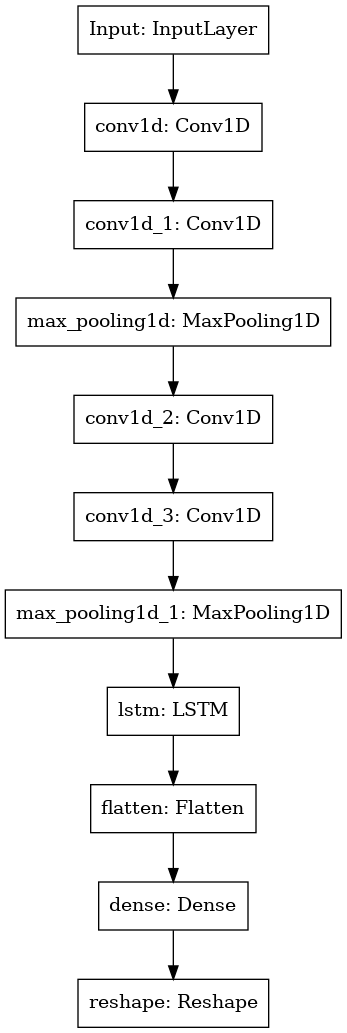

In [14]:
tfk.utils.plot_model(model, expand_nested=True)

In [15]:
future_window = 864

In [16]:
def autoregression_pred(model,window):
    last_window = train_scaled[-window:]
    last_window = np.expand_dims(last_window, axis=0)
    pred = model.predict(last_window)
    last_window.shape, pred.shape

    pred = np.array([])
    X_temp = last_window
    for t in range(future_window):
        pred_temp = model.predict(X_temp)
        pred_temp = np.expand_dims(pred_temp, axis=0)
        if(len(pred)==0):
            pred = pred_temp
        else:
            pred = np.concatenate((pred,pred_temp),axis=1)
        X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)
        
    pred_scaled = pred[0]*(train_max-train_min)+train_min
    return pred_scaled    


def autoregression_pred_multiout(model,window,future):
    last_window = train_scaled[-window:]
    last_window = np.expand_dims(last_window, axis=0)
    pred = model.predict(last_window)
    last_window.shape, pred.shape
    pred = np.array([])
    X_temp = last_window
    for t in range(0,future_window,future):
        pred_temp = model.predict(X_temp)
        #pred_temp = np.expand_dims(pred_temp, axis=0)
        if(len(pred)==0):
            pred = pred_temp
        else:
            pred = np.concatenate((pred,pred_temp),axis=1)
        X_temp = np.concatenate((X_temp[:,future:,:],pred_temp), axis=1)

    pred_scaled = pred[0]*(train_max-train_min)+train_min
    return pred_scaled

In [17]:
def compute_err(pred_scaled,return_values=True):
    rmse = np.sqrt(tfk.metrics.mse(test_raw[:future_window].flatten(),pred_scaled.flatten()))
    mae = (tfk.metrics.mae(test_raw[:future_window].flatten(),pred_scaled.flatten())).numpy()
    print("RMSE: " + str(rmse) + "  MAE: " + str(mae))
    if(return_values):
        return rmse,mae

In [18]:
pred_array = []
for i,model in enumerate(models_array):
    pred_array.append(autoregression_pred_multiout(model,sequence_length,future))

In [19]:
best_rmse = 1e7
best_model = 0

for i,pred in enumerate(pred_array):
    rmse,mae = compute_err(pred)
    if(rmse < best_rmse):
        best_rmse = rmse
        best_model = i
        
print("\nBest model is " + str(models_lables[best_model]))

RMSE: 7.694566939167146  MAE: 4.981926199042513

Best model is conv lstm


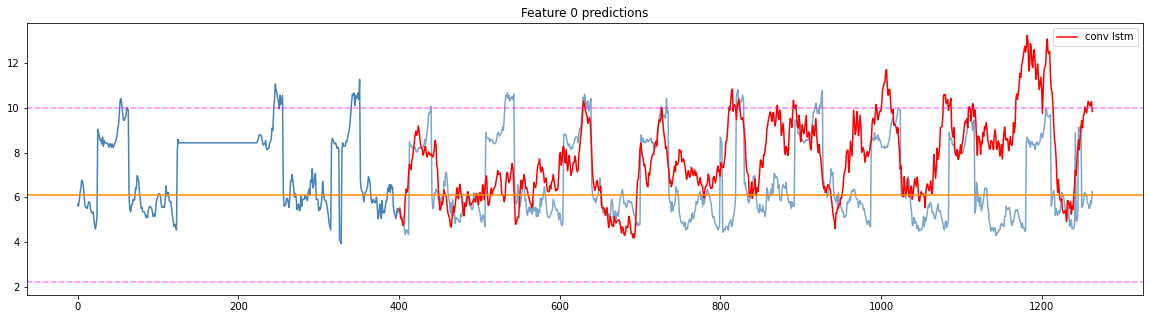

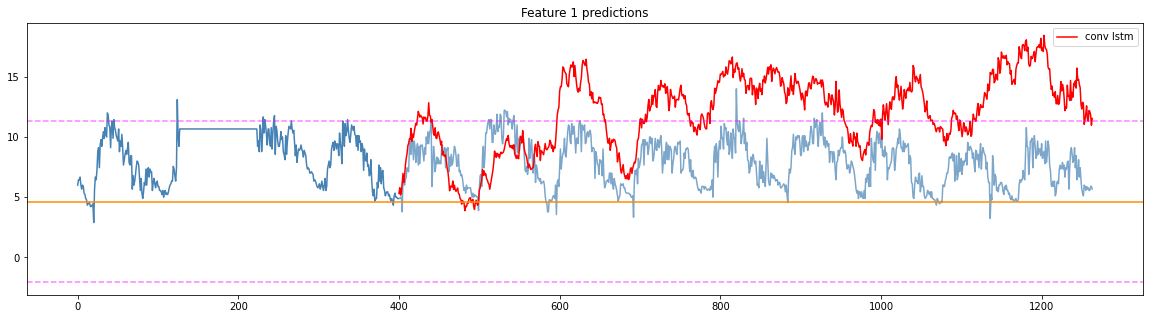

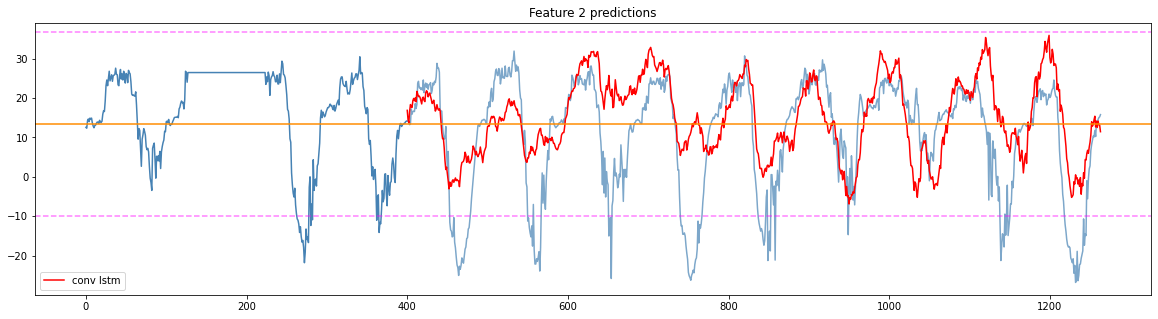

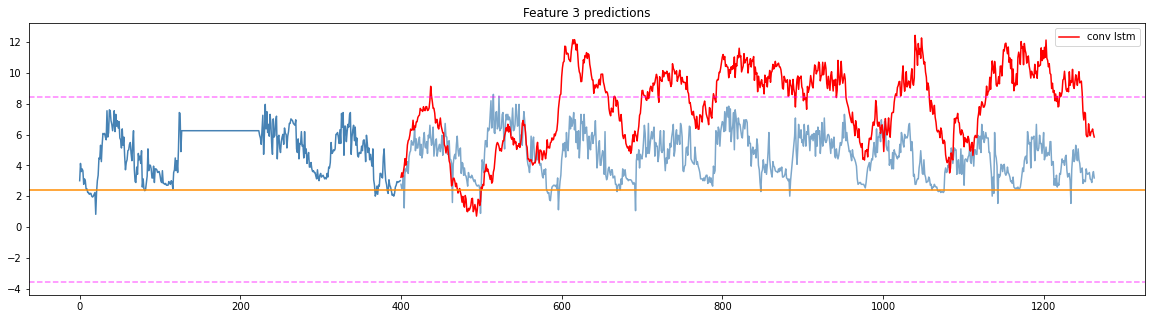

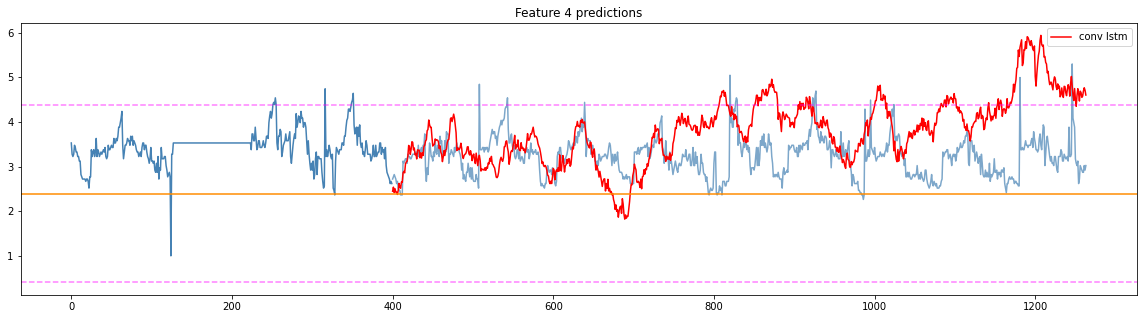

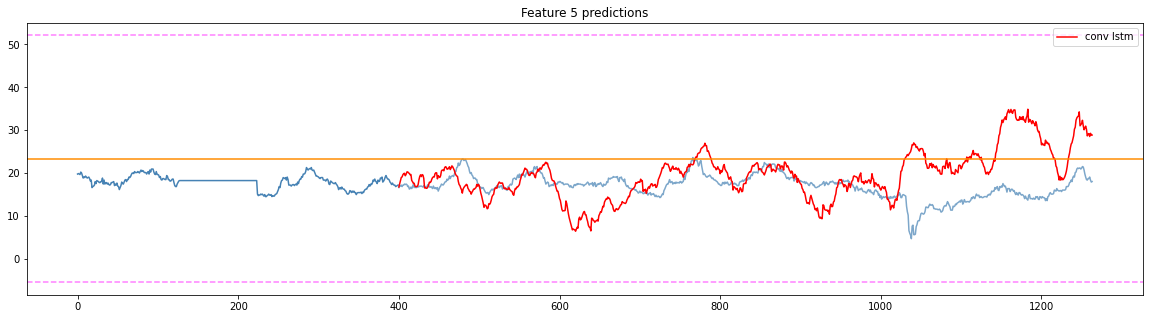

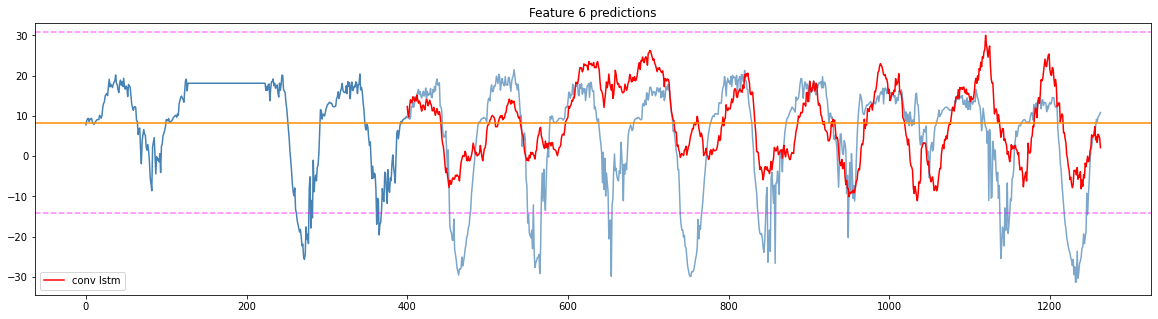

In [20]:
colors = ['#7d34fa','#fa34f3','#032cfc','#ff006f','#00ffd5','#62ff57']
window = sequence_length
for i in range(7):
    plt.figure(figsize=(20,5))
    plt.plot(range(window),train_raw[-window:,i],color="steelblue")
    plt.plot(range(window,window+future_window),test_raw[:future_window,i],color="steelblue",alpha=.7)
    for j,pred in enumerate(pred_array):
        if(j!=best_model): 
            alpha_val = 0.35
            c = colors[j]
        else: 
            alpha_val = 1
            c = '#ff0000'
        plt.plot(range(window,window+future_window),pred[:,i],label=models_lables[j],alpha=alpha_val,color=c)
    plt.axhline(y=X_mean[i],color='darkorange',linestyle='-')
    plt.axhline(y=X_mean[i]+2*X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.axhline(y=X_mean[i]-2*X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.title('Feature ' + str(i) + ' predictions')
    plt.legend()


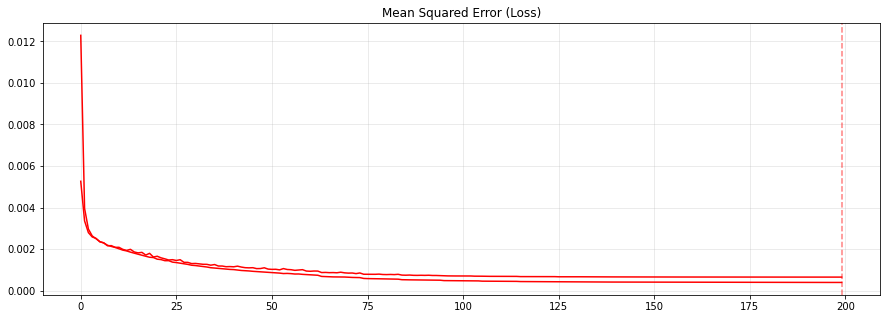

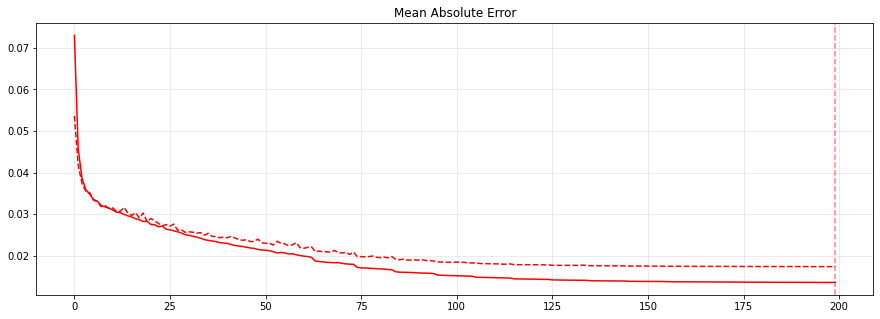

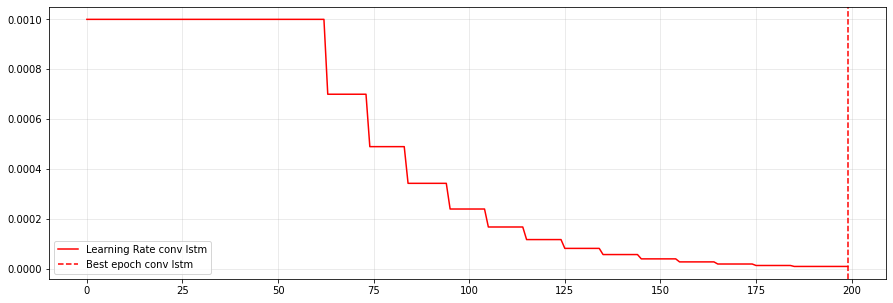

In [21]:
fig_size = (15,5)
plt.figure(figsize=fig_size)


for i,history in enumerate(history_array):
    if(i!=best_model): 
        alpha_val = 0.35
        c = colors[i]
    else: 
        alpha_val = 1
        c = '#ff0000'
    best_epoch = np.argmin(history['val_loss'])
    plt.plot(history['loss'], label='Training loss '+ models_lables[i],alpha=alpha_val,color=c)
    plt.plot(history['val_loss'], label='Validation loss '+ models_lables[i],alpha=alpha_val,color=c)
    plt.axvline(x=best_epoch, label='Best epoch ' + models_lables[i], alpha=.5, ls='--',color=c)

plt.title('Mean Squared Error (Loss)')
#plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)

for i,history in enumerate(history_array):
    if(i!=best_model): 
        alpha_val = 0.35
        c = colors[i]
    else: 
        alpha_val = 1
        c = '#ff0000'
    best_epoch = np.argmin(history['val_loss'])
    plt.plot(history['mae'], label='Training accuracy '+ models_lables[i],alpha=alpha_val,color=c)
    plt.plot(history['val_mae'], label='Validation accuracy '+ models_lables[i],alpha=alpha_val,ls='--',color=c)
    plt.axvline(x=best_epoch, label='Best epoch '+ models_lables[i], alpha=.5, ls='--',color=c)
    
plt.title('Mean Absolute Error')
#plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
for i,history in enumerate(history_array):
    if(i!=best_model): 
        alpha_val = 0.35
        c = colors[i]
    else: 
        alpha_val = 1
        c = '#ff0000'
    best_epoch = np.argmin(history['val_loss'])
    plt.plot(history['lr'], label='Learning Rate '+ models_lables[i],alpha=alpha_val,color=c)
    plt.axvline(x=best_epoch, label='Best epoch '+ models_lables[i], alpha=alpha_val, ls='--',color=c)

plt.legend()
plt.grid(alpha=.3)
plt.show()

In [22]:
import shutil
from os import path
def save_model(model,filename):
    model.save(filename)
    src = path.realpath(filename)
    root_dir, tail = path.split(src)
    shutil.make_archive(filename, 'zip', filename)
    print(filename + ' saved!')

In [23]:
for i,model in enumerate(models_array):
    save_model(model,models_lables[i])
#save_model(model_2,'model_2')

2022-01-18 00:51:27.083984: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


conv lstm saved!


In [24]:
#!rm -r model model.zip model_1 model_1.zip model_2 model_2.zip
#!zip -r model.zip model
#model = tfk.models.load_model('model')